In [1]:
import numpy as np # For array operations
import matplotlib.pyplot as plt
import cv2 as cv # Mostly for showing and normalization
import os #To iterate through directories and join paths
from sklearn import preprocessing
from random import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
from random import randint
import h5py
from keras.layers import BatchNormalization
from keras.utils import img_to_array
from keras.models import Sequential, model_from_json
from keras.callbacks import TensorBoard
import time
import pickle

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


In [4]:
tf.__version__

'2.11.0-dev20220812'

In [5]:
def resize_image(img_array, height, width):
    return cv.resize(img_array, (height, width))

# def plot_image(img_array):
#     plt.imshow(img_array, cmap='gray')
#     plt.show()

In [6]:
img_height = 120
img_width = 50
classes = ['0', '1']
class_names = ['No-Fracture', 'Fracture']

In [3]:
data_dir = r"D:\Ammar's\FYP_DATA\Dataset\(FR NO-FR) Dataset With Augmentation"

In [10]:
# Creating training data
from tqdm import tqdm

def get_data(data_dir, classes, img_width, img_height):
    data = []
    for a_class in classes:
        path = os.path.join(data_dir, a_class)
        class_num = classes.index(a_class)

        for image in tqdm(os.listdir(path)):
            img_array = cv.imread(os.path.join(path, image), cv.IMREAD_GRAYSCALE)
            resized_img_array = resize_image(img_array, img_width, img_height)
            data.append([resized_img_array, class_num])
            
    return data

In [4]:
import random
seed = 42
random.seed(seed)

In [11]:
data = get_data(data_dir, classes, img_width, img_height)
random.shuffle(data)

100%|██████████| 13550/13550 [03:28<00:00, 65.10it/s]


In [ ]:
import pickle 
with open("/data.pkl", "wb") as f:
  pickle.dump(data, f)

In [ ]:
import pickle 
data = []
with open("/content/drive/MyDrive/Shared Datasets/Saved Data/fr_aug_loaded_data/data.pkl", "rb") as f:
  data = pickle.load(f)

In [12]:
# Seperating features from the labels
def sep_features_labels(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    return X, y

In [13]:
X, y = sep_features_labels(data)

In [14]:
#Reshaping the features 
def reshape(X, y, img_width, img_height):
    X = np.array(X).reshape(-1, img_height, img_width, 1)
    X = np.array(X).astype('float')/255.0
    y = np.asarray(y).astype('float32').reshape((-1,1))
    
    return X, y

In [15]:
X, y = reshape(X, y, img_width, img_height)
print(f'Data Samples: {X.shape}')

Data Samples: (27100, 120, 50, 1)


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=seed)

In [5]:
saved_datadir = r"D:\Ammar's\FYP_DATA\Saved Data (Classification)\fr-aug-binary-classification"

In [18]:
# Save data

with open(os.path.join(saved_datadir, "X_train.pkl"), "wb") as f:
  pickle.dump(X_train, f)

with open(os.path.join(saved_datadir, "y_train.pkl"), "wb") as f:
  pickle.dump(y_train, f)


with open(os.path.join(saved_datadir, "X_test.pkl"), "wb") as f:
  pickle.dump(X_test, f)

with open(os.path.join(saved_datadir, "y_test.pkl"), "wb") as f:
  pickle.dump(y_test, f)

In [6]:
# Load data

with open(os.path.join(saved_datadir, "X_train.pkl"), "rb") as f:
  X_train = pickle.load(f)

with open(os.path.join(saved_datadir, "y_train.pkl"), "rb") as f:
  y_train = pickle.load(f)

with open(os.path.join(saved_datadir, "X_test.pkl"), "rb") as f:
  X_test = pickle.load(f)

with open(os.path.join(saved_datadir, "y_test.pkl"), "rb") as f:
  y_test = pickle.load(f)

In [7]:
print(X_train.shape)
print(X_test.shape)

(21680, 120, 50, 1)
(5420, 120, 50, 1)


In [21]:
data = []

In [11]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam, RMSprop, SGD

def define_model(neurons, dense_layers, bn, dropouts, opt):
  model = Sequential()
  
  for i, nodes in enumerate(neurons):
    if i == 0:
      model.add(Conv2D(nodes, (3, 3), input_shape=X_train.shape[1:], activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      if bn:
        model.add(BatchNormalization())
    else:
      model.add(Conv2D(nodes, (3, 3), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  if len(dense_layers) == len(dropouts) or len(dense_layers) < len(dropouts):
    for i, nodes in enumerate(dense_layers):
      model.add(Dense(nodes, activation='relu'))
      model.add(Dropout(dropouts[i]))
  elif len(dense_layers) > len(dropouts):
    for i, dropout in enumerate(dropouts):
      model.add(Dense(dense_layers[i], activation='relu'))
      model.add(Dropout(dropout))

  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss="binary_crossentropy", optimizer=opt(), metrics=["accuracy"])
  return model

In [12]:
tf_seed = 42
tf.random.set_seed(tf_seed)

model = KerasClassifier(build_fn=define_model, verbose=1) 

neurons = [[32, 64], [32, 64, 128], [32, 64, 128, 128], [32, 64, 128, 256], [64, 128, 256, 256]]
# neurons = [[32, 64, 128, 128], [32, 64, 128, 256], [64, 128, 256, 256]]
opt = [SGD, RMSprop, Adam]
dense_layers = [[], [512], [256], [256, 256], [512, 256], [512, 512]]
dropouts = [[0.2], [0.5], [0.2, 0.2], [0.2, 0.5], [0.5, 0.5]]
bn = [True, False]

param_grid = dict(neurons=neurons, dense_layers=dense_layers, bn=bn, dropouts=dropouts, opt=opt, batch_size=[132], epochs=[20])
grid = GridSearchCV(estimator=model, param_grid=param_grid, return_train_score=True, n_jobs=1, cv=3, error_score='raise')

grid_result = grid.fit(X_train, y_train)

C:\Users\Noureen Fatima\AppData\Local\Temp\ipykernel_3840\2714794771.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=define_model, verbose=1)


Epoch 1/20
110/110 [==============================] - 8s 14ms/step - loss: 0.5702 - accuracy: 0.6941
Epoch 2/20
110/110 [==============================] - 1s 13ms/step - loss: 0.4856 - accuracy: 0.7433
Epoch 3/20
110/110 [==============================] - 1s 13ms/step - loss: 0.4687 - accuracy: 0.7587
Epoch 4/20
110/110 [==============================] - 1s 13ms/step - loss: 0.4573 - accuracy: 0.7676
Epoch 5/20
110/110 [==============================] - 1s 13ms/step - loss: 0.4458 - accuracy: 0.7753
Epoch 6/20
110/110 [==============================] - 1s 13ms/step - loss: 0.4345 - accuracy: 0.7785
Epoch 7/20
110/110 [==============================] - 1s 13ms/step - loss: 0.4240 - accuracy: 0.7868
Epoch 8/20
110/110 [==============================] - 1s 13ms/step - loss: 0.4192 - accuracy: 0.7904
Epoch 9/20
110/110 [==============================] - 1s 13ms/step - loss: 0.4130 - accuracy: 0.7931
Epoch 10/20
110/110 [==============================] - 1s 13ms/step - loss: 0.4047 - accura

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))

In [ ]:
pickle_out = open('/content/drive/MyDrive/Shared Datasets/gridsearch/grid_fr_aug_binary.pickle', "wb")
pickle.dump(grid_result, pickle_out)
pickle_out.close()

In [ ]:
test_scores = grid_result.cv_results_['mean_test_score']
train_scores = grid_result.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)

In [ ]:
model = define_model([32, 64, 128, 128], [256, 512], True, [0.2, 0.5])

es = tf.keras.callbacks.EarlyStopping (
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    mode='max'
)

cp = tf.keras.callbacks.ModelCheckpoint(
    'best_aug.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=30, callbacks=[es, cp], verbose=2)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.60625, saving model to best_aug.h5
140/140 - 14s - loss: 0.5011 - accuracy: 0.7318 - val_loss: 0.6580 - val_accuracy: 0.6063 - 14s/epoch - 98ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.60625 to 0.67202, saving model to best_aug.h5
140/140 - 4s - loss: 0.4163 - accuracy: 0.7920 - val_loss: 0.5918 - val_accuracy: 0.6720 - 4s/epoch - 30ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.67202 to 0.71348, saving model to best_aug.h5
140/140 - 4s - loss: 0.3847 - accuracy: 0.8153 - val_loss: 0.5087 - val_accuracy: 0.7135 - 4s/epoch - 30ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.71348 to 0.82027, saving model to best_aug.h5
140/140 - 4s - loss: 0.3635 - accuracy: 0.8316 - val_loss: 0.3838 - val_accuracy: 0.8203 - 4s/epoch - 30ms/step
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.82027
140/140 - 4s - loss: 0.3390 - accuracy: 0.8444 - val_loss: 0.3701 - val_accuracy: 0.8203 - 4s/epoch - 32ms

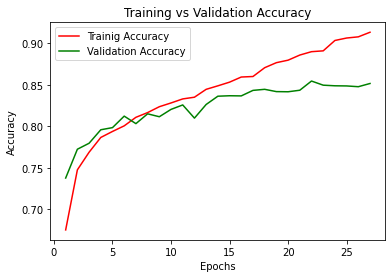

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

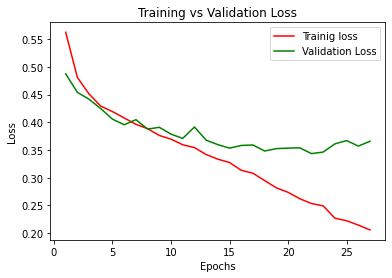

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# LOAD THE MODEL WEIGHTS

from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/Shared Datasets/Saved Models/early_stopping_models/1-best_aug.h5")
model.evaluate(X_test, y_test)

128/128 [==============================] - 14s 109ms/step - loss: 0.3215 - accuracy: 0.8595


[0.3214503228664398, 0.8595325946807861]

In [ ]:
y_pred = model.predict(X_test)
y_pred = [[np.where(val >= 0.5, 1, 0)] for lst in y_pred for val in lst]
y_pred = np.array(y_pred) 

128/128 [==============================] - 16s 125ms/step


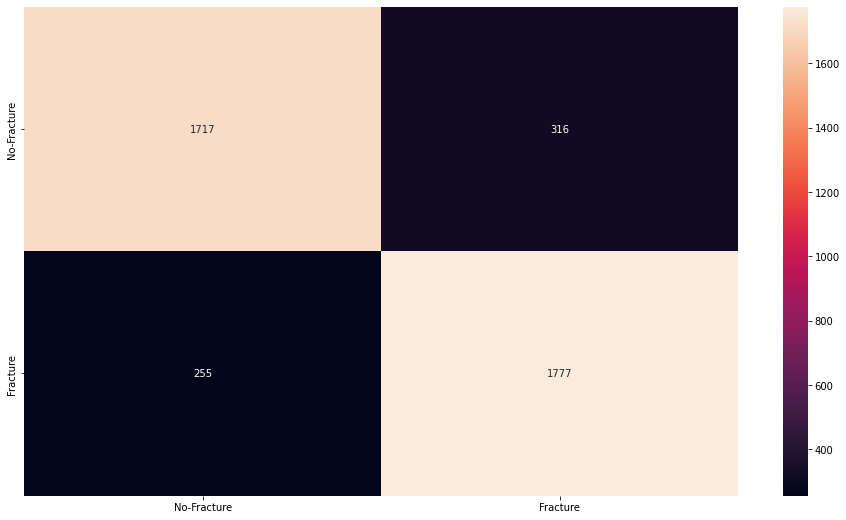

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import plot_confusion_matrix

def plot_conf_matrix(X_test, y_test, classifier, title):
    y_pred = model.predict(X_test)
    y_pred = [round(pred[0]) for pred in y_pred]

    cm = confusion_matrix(y_test, y_pred)

    color = 'black'
    matrix = plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.PuBu_r)
    matrix.ax_.set_title(title, color=color)
    plt.xlabel('Predicted Label', color=color)
    plt.ylabel('True Label', color=color)
    plt.gcf().axes[0].tick_params(colors=color)
    plt.gcf().axes[1].tick_params(colors=color)
    plt.show()
    
# plot_conf_matrix(X_test, y_test, model, 'Confusion Matrix')

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_test, y_pred)
class_labels=['No-Fracture', 'Fracture']
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_pred, target_names=class_labels)
print(cr)

              precision    recall  f1-score   support

 No-Fracture       0.87      0.84      0.86      2033
    Fracture       0.85      0.87      0.86      2032

    accuracy                           0.86      4065
   macro avg       0.86      0.86      0.86      4065
weighted avg       0.86      0.86      0.86      4065



In [ ]:
# best-aug TRAINED ON 30 EPOCHS WITH EARLY STOPPING CALLBACK, PATIENCE=8

model = define_model([32, 64, 128, 128], [], True, [512])

es = tf.keras.callbacks.EarlyStopping (
    monitor='val_accuracy',
    patience=8,
    verbose=1,
    mode='max'
)

cp = tf.keras.callbacks.ModelCheckpoint(
    'best_aug_30epochs.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=30, callbacks=[es, cp], verbose=2)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.67615, saving model to best_aug_30epochs.h5
140/140 - 209s - loss: 0.4808 - accuracy: 0.7511 - val_loss: 0.6568 - val_accuracy: 0.6761 - 209s/epoch - 1s/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.67615 to 0.72976, saving model to best_aug_30epochs.h5
140/140 - 207s - loss: 0.4141 - accuracy: 0.7995 - val_loss: 0.5863 - val_accuracy: 0.7298 - 207s/epoch - 1s/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.72976 to 0.79184, saving model to best_aug_30epochs.h5
140/140 - 205s - loss: 0.3812 - accuracy: 0.8191 - val_loss: 0.4889 - val_accuracy: 0.7918 - 205s/epoch - 1s/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.79184 to 0.80399, saving model to best_aug_30epochs.h5
140/140 - 203s - loss: 0.3657 - accuracy: 0.8283 - val_loss: 0.4301 - val_accuracy: 0.8040 - 203s/epoch - 1s/step
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.80399
140/140 - 205s - loss: 0.3307 - accuracy: 0.8493 - val_loss: 0.4

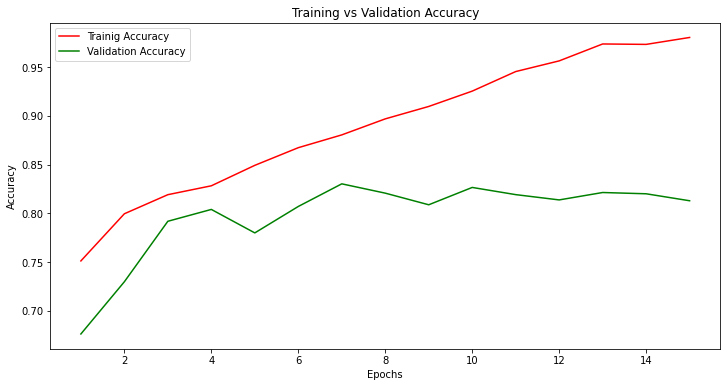

In [ ]:
plt.figure(figsize=(12,6))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

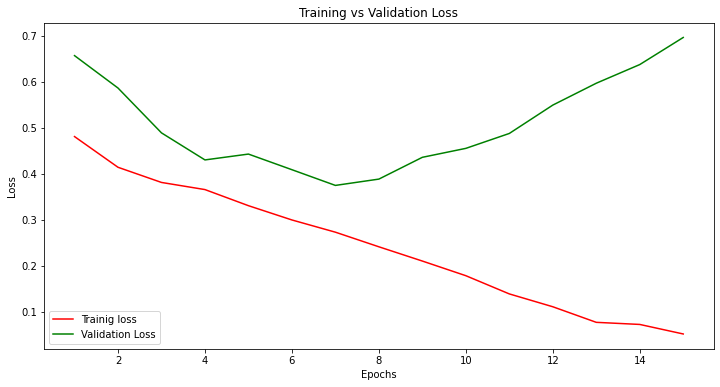

In [ ]:
plt.figure(figsize=(12,6))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# best-aug TRAINED ON 30 EPOCHS WITH EARLY STOPPING CALLBACK, PATIENCE=8

model = define_model([32, 64, 128, 128], [], False, [512])

es = tf.keras.callbacks.EarlyStopping (
    monitor='val_accuracy',
    patience=8,
    verbose=1,
    mode='max'
)

cp = tf.keras.callbacks.ModelCheckpoint(
    'best_aug_30epochs.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=30, callbacks=[es, cp], verbose=2)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.76579, saving model to best_aug_30epochs.h5
140/140 - 196s - loss: 0.5447 - accuracy: 0.7006 - val_loss: 0.4696 - val_accuracy: 0.7658 - 196s/epoch - 1s/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.76579 to 0.78142, saving model to best_aug_30epochs.h5
140/140 - 195s - loss: 0.4501 - accuracy: 0.7747 - val_loss: 0.4371 - val_accuracy: 0.7814 - 195s/epoch - 1s/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.78142 to 0.78880, saving model to best_aug_30epochs.h5
140/140 - 195s - loss: 0.4292 - accuracy: 0.7887 - val_loss: 0.4292 - val_accuracy: 0.7888 - 195s/epoch - 1s/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.78880 to 0.79444, saving model to best_aug_30epochs.h5
140/140 - 192s - loss: 0.4088 - accuracy: 0.8020 - val_loss: 0.4166 - val_accuracy: 0.7944 - 192s/epoch - 1s/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.79444 to 0.79944, saving model to best_aug_30epochs.h5
140/140 - 195s - loss:

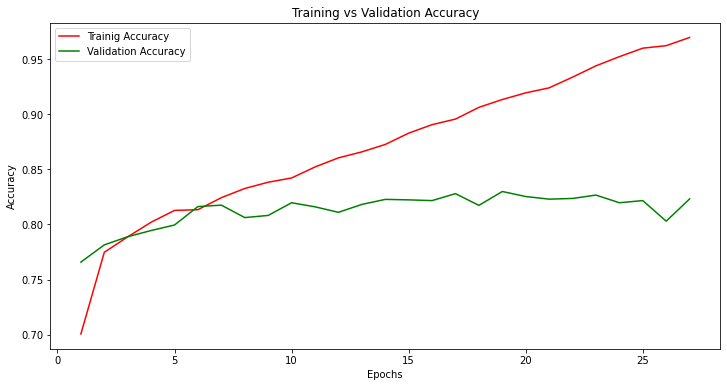

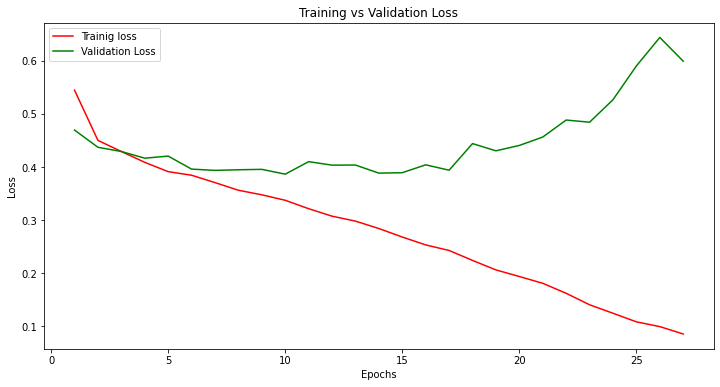

In [ ]:
plt.figure(figsize=(12,6))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(12,6))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = define_model([32, 64, 128, 128], [], True, [])

es = tf.keras.callbacks.EarlyStopping (
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    mode='max'
)

cp = tf.keras.callbacks.ModelCheckpoint(
    'best_aug.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=30, callbacks=[es, cp], verbose=2)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.68917, saving model to best_aug.h5
140/140 - 5s - loss: 0.4885 - accuracy: 0.7415 - val_loss: 0.6493 - val_accuracy: 0.6892 - 5s/epoch - 37ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.68917 to 0.71087, saving model to best_aug.h5
140/140 - 4s - loss: 0.4127 - accuracy: 0.7982 - val_loss: 0.5774 - val_accuracy: 0.7109 - 4s/epoch - 30ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.71087 to 0.72281, saving model to best_aug.h5
140/140 - 4s - loss: 0.3822 - accuracy: 0.8139 - val_loss: 0.5262 - val_accuracy: 0.7228 - 4s/epoch - 30ms/step
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.72281
140/140 - 4s - loss: 0.3606 - accuracy: 0.8285 - val_loss: 0.5192 - val_accuracy: 0.7191 - 4s/epoch - 30ms/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.72281 to 0.78554, saving model to best_aug.h5
140/140 - 4s - loss: 0.3385 - accuracy: 0.8430 - val_loss: 0.4159 - val_accuracy: 0.7855 - 4s/epoch - 30ms/s

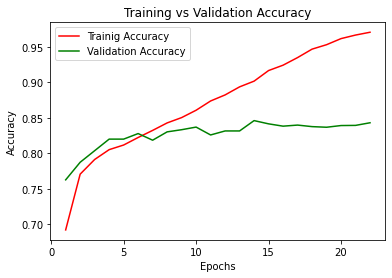

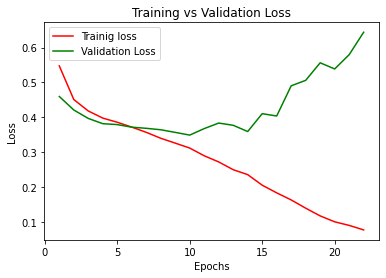

In [ ]:
# plt.figure(figsize=(12,6))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# plt.figure(figsize=(12,6))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# val_data = get_data(r'/content/fr_dataset/val', classes, img_width, img_height)
# shuffle(val_data)
# X_val, y_val = sep_features_labels(val_data)
# X_val, y_val = reshape(X_val, y_val, img_width, img_height)

In [ ]:
# test_data = get_data(r'/content/fr_dataset/test', classes, img_width, img_height)
# shuffle(test_data)
# X_test, y_test = sep_features_labels(test_data)
# X_test, y_test = reshape(X_test, y_test, img_width, img_height)

In [ ]:
pickle_save('X_test', 'y_test', X_test, y_test)

In [ ]:
pickle_save('X_val', 'y_val', X_val, y_val)

In [ ]:
X_test, y_test = pickle_load('/content/drive/MyDrive/Shared Datasets/Loaded data (fr_aug_binary)/X_test.pickle', '/content/drive/MyDrive/Shared Datasets/Loaded data (fr_aug_binary)/y_test.pickle')

In [ ]:
X_val, y_val = pickle_load('/content/drive/MyDrive/Shared Datasets/Loaded data (fr_aug_binary)/X_val.pickle', '/content/drive/MyDrive/Shared Datasets/Loaded data (fr_aug_binary)/y_val.pickle')

In [ ]:
training_data = []
val_data = []
test_data = []

In [ ]:
model.load_weights('/content/best_aug.h5')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 118, 48, 32)       320       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 59, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 57, 22, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 28, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 26, 9, 128)        73856     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 13, 4, 128)      

In [ ]:
model.evaluate(X_test, y_test)

85/85 [==============================] - 0s 5ms/step - loss: 0.3507 - accuracy: 0.8513


[0.35071542859077454, 0.8512915372848511]

**OLD CODE**

In [ ]:
dense_layers = [0, 1]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3, 4]

models = []
histories = list(range(0, (2 * 3* 4)))
counter = 0

for dense_layer in dense_layers:
	for layer_size in layer_sizes:
		for conv_layer in conv_layers:
			NAME = f'wri-{conv_layer}-conv-{layer_size}-layer-{dense_layer}-dense-{int(time.time())}'
			tensorboard = TensorBoard(log_dir=f'/content/logs_fr_aug_binary/{NAME}')
			# %load_ext tensorboard
			# %tensorboard --logdir logs      

			print(NAME)
			model = Sequential()
			model.add(Conv2D(layer_size, (3, 3), input_shape=X_train.shape[1:], activation='relu'))
			model.add(BatchNormalization())
			model.add(MaxPooling2D(pool_size=(2, 2)))

			for i in range(conv_layer - 1):
					model.add(Conv2D(layer_size, (3, 3), activation='relu'))
					model.add(MaxPooling2D(pool_size=(2, 2)))

			model.add(Flatten())
			for l in range(dense_layer):
				model.add(Dense(512, activation='relu'))
				model.add(Dropout(0.5))

			model.add(Dense(1, activation='sigmoid'))
			model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
			histories[counter] = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=10, callbacks=[tensorboard])
			counter += 1

			val_loss, val_acc = model.evaluate(X_val, y_val)
			train_loss, train_acc = model.evaluate(X_train, y_train)
			print(f'Val Loss: {val_loss}, Val Acc: {val_acc}')
			models.append([f'{NAME}, LOSS: {val_loss}, ACC: {val_acc}, Train_Loss: {train_loss}, Train_Acc: {train_acc}', model])

wri-1-conv-32-layer-0-dense-1664220803
Epoch 1/10
144/144 [==============================] - 13s 15ms/step - loss: 0.5447 - accuracy: 0.7340 - val_loss: 0.6487 - val_accuracy: 0.5862
Epoch 2/10
144/144 [==============================] - 2s 12ms/step - loss: 0.4163 - accuracy: 0.7919 - val_loss: 0.6063 - val_accuracy: 0.6030
Epoch 3/10
144/144 [==============================] - 2s 12ms/step - loss: 0.3695 - accuracy: 0.8215 - val_loss: 0.4942 - val_accuracy: 0.7744
Epoch 4/10
144/144 [==============================] - 2s 12ms/step - loss: 0.3458 - accuracy: 0.8377 - val_loss: 0.4520 - val_accuracy: 0.7662
Epoch 5/10
144/144 [==============================] - 2s 12ms/step - loss: 0.3211 - accuracy: 0.8522 - val_loss: 0.4561 - val_accuracy: 0.7646
Epoch 6/10
144/144 [==============================] - 2s 12ms/step - loss: 0.2962 - accuracy: 0.8661 - val_loss: 0.4755 - val_accuracy: 0.7598
Epoch 7/10
144/144 [==============================] - 2s 12ms/step - loss: 0.2743 - accuracy: 0.8813 -

In [ ]:
for index, model in enumerate(models):
  print(f'{index: } {model[0]}')

 0 wri-1-conv-32-layer-0-dense-1664220803, LOSS: 0.5532374382019043, ACC: 0.769003689289093, Train_Loss: 0.18300090730190277, Train_Acc: 0.9319978952407837
 1 wri-2-conv-32-layer-0-dense-1664220853, LOSS: 0.4179886281490326, ACC: 0.8086715936660767, Train_Loss: 0.2748391628265381, Train_Acc: 0.879599392414093
 2 wri-3-conv-32-layer-0-dense-1664220878, LOSS: 0.3912418782711029, ACC: 0.8153136372566223, Train_Loss: 0.2982330024242401, Train_Acc: 0.864997386932373
 3 wri-4-conv-32-layer-0-dense-1664220923, LOSS: 0.42661479115486145, ACC: 0.8022140264511108, Train_Loss: 0.3337646424770355, Train_Acc: 0.8371639251708984
 4 wri-1-conv-64-layer-0-dense-1664220950, LOSS: 0.6938149333000183, ACC: 0.7374538779258728, Train_Loss: 0.19134141504764557, Train_Acc: 0.9224038124084473
 5 wri-2-conv-64-layer-0-dense-1664220981, LOSS: 0.45700985193252563, ACC: 0.805535078048706, Train_Loss: 0.2095324546098709, Train_Acc: 0.9128624200820923
 6 wri-3-conv-64-layer-0-dense-1664221021, LOSS: 0.4838226139545

In [ ]:
wri_4_conv = models[15][1]

In [ ]:
history_wri_4_conv = histories[15]

In [ ]:
wri_4_conv.evaluate(X_test, y_test)

85/85 [==============================] - 10s 3ms/step - loss: 0.3541 - accuracy: 0.8358


[0.3541091978549957, 0.8357933759689331]

In [ ]:
wri_4_conv.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 118, 48, 32)       320       
                                                                 
 batch_normalization_15 (Bat  (None, 118, 48, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 59, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 57, 22, 32)        9248      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 28, 11, 32)       0         
 g2D)                                                            
                                                     

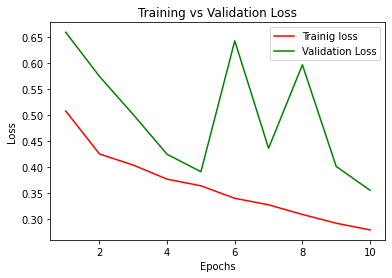

In [ ]:
loss = history_wri_4_conv.history['loss']
val_loss = history_wri_4_conv.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

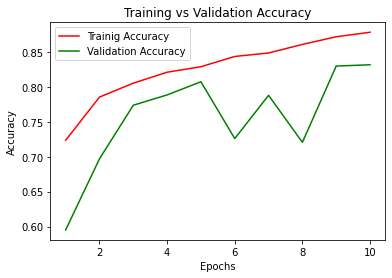

In [ ]:
acc = history_wri_4_conv.history['accuracy']
val_acc = history_wri_4_conv.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
pickle_out = open('models.pickle', "wb")
pickle.dump(models, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open('histories.pickle', "wb")
pickle.dump(histories, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open('/content/drive/MyDrive/Shared Datasets/Loaded data (fr_aug_binary)/models.pickle', 'rb')
models = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
pickle_in = open('/content/drive/MyDrive/Shared Datasets/Loaded data (fr_aug_binary)/histories.pickle', 'rb')
histories = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
def save_model(model_name, model):
    model_json = model.to_json()
    with open(f"{model_name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{model_name}.h5")
    print("Saved model to disk")

def load_model(model_json, model_weights, model_name):
    json_file = open(model_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    conv_model = model_from_json(loaded_model_json)
    # load weights into new model
    conv_model.load_weights(model_weights)
    print("Loaded model from disk")
    return conv_model, model_name

In [ ]:
save_model('wri-4-conv-32-layer-1-dense', wri_4_conv)

Saved model to disk


In [ ]:
wri_4_conv, model_name = load_model('/content/drive/MyDrive/Shared Datasets/Saved Models/fr_aug_binary_classification/wri-4-conv-32-layer-1-dense.json', 
                        '/content/drive/MyDrive/Shared Datasets/Saved Models/fr_aug_binary_classification/wri-4-conv-32-layer-1-dense.h5',
                        'wri-4-conv-32-layer-1-dense')
wri_4_conv.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

Loaded model from disk


In [ ]:
y_pred = wri_4_conv.predict(X_test)

In [ ]:
y_pred = [[np.where(val >= 0.5, 1, 0)] for lst in y_pred for val in lst]

In [ ]:
y_pred = np.array(y_pred) 

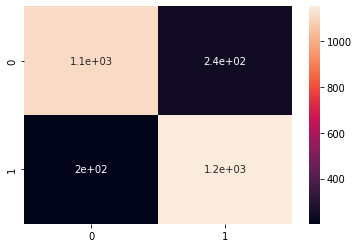

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)

In [ ]:
# 134 Page Configuration:

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(120, 50, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=132, epochs=10)

Epoch 1/10
144/144 [==============================] - 4s 22ms/step - loss: 0.5202 - accuracy: 0.7177 - val_loss: 0.6750 - val_accuracy: 0.5487
Epoch 2/10
144/144 [==============================] - 3s 20ms/step - loss: 0.4302 - accuracy: 0.7861 - val_loss: 0.5857 - val_accuracy: 0.7129
Epoch 3/10
144/144 [==============================] - 3s 20ms/step - loss: 0.4059 - accuracy: 0.8047 - val_loss: 0.5256 - val_accuracy: 0.7828
Epoch 4/10
144/144 [==============================] - 3s 20ms/step - loss: 0.3822 - accuracy: 0.8207 - val_loss: 0.4135 - val_accuracy: 0.8210
Epoch 5/10
144/144 [==============================] - 3s 20ms/step - loss: 0.3577 - accuracy: 0.8352 - val_loss: 0.3849 - val_accuracy: 0.8077
Epoch 6/10
144/144 [==============================] - 3s 20ms/step - loss: 0.3444 - accuracy: 0.8424 - val_loss: 0.3677 - val_accuracy: 0.8297
Epoch 7/10
144/144 [==============================] - 3s 20ms/step - loss: 0.3211 - accuracy: 0.8539 - val_loss: 0.3473 - val_accuracy: 0.8356

In [ ]:
model.evaluate(X_test, y_test)

85/85 [==============================] - 0s 3ms/step - loss: 0.3317 - accuracy: 0.8509


[0.33167096972465515, 0.8509225249290466]

In [ ]:
model.evaluate(X_train, y_train)

593/593 [==============================] - 2s 3ms/step - loss: 0.2375 - accuracy: 0.9078


[0.23745982348918915, 0.9078018069267273]

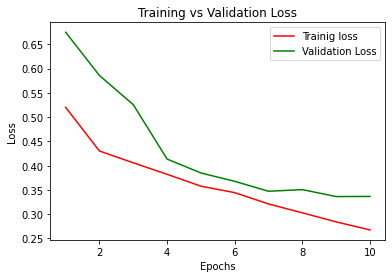

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

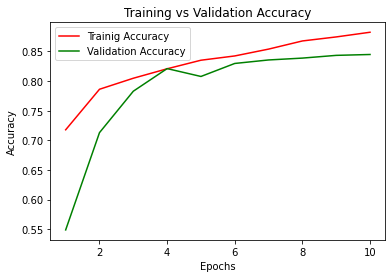

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
save_model('10epoch-134-config', model)

Saved model to disk


In [ ]:
model, model_name = load_model('/content/drive/MyDrive/Shared Datasets/Saved Models/fr_aug_binary_classification/10epoch-134-config.json', 
                        '/content/drive/MyDrive/Shared Datasets/Saved Models/fr_aug_binary_classification/10epoch-134-config.h5',
                        '10epoch-134-config')
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

Loaded model from disk


128/128 [==============================] - 17s 137ms/step


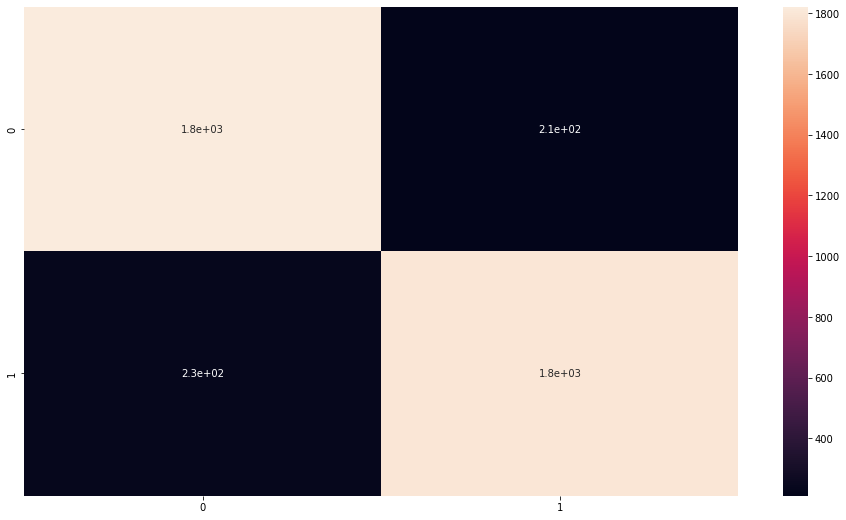

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = model.predict(X_test)
y_pred = [[np.where(val >= 0.5, 1, 0)] for lst in y_pred for val in lst]
y_pred = np.array(y_pred) 

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_test, y_pred)
class_labels=['No-Fracture', 'Fracture']
sns.heatmap(cm, annot=True)

In [ ]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 118, 48, 32)       320       
                                                                 
 batch_normalization_28 (Bat  (None, 118, 48, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 59, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 57, 22, 64)        18496     
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 28, 11, 64)       0         
 g2D)                                                            
                                                     